In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.patheffects as path_effects

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [2]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls_historical.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls_historical.csv")

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3546669014.py:2: DtypeWarning: Columns (16,17,26,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(president_polls_url)


In [3]:
df = pd.read_csv("../Data/raw/president_polls_historical.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
#df.loc[(df['party'].isin(['REP', 'DEM']) == False) & (df['answer'] != 'Kennedy'), 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3189127009.py:1: DtypeWarning: Columns (17,18,27,29,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/raw/president_polls_historical.csv")


In [4]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3015971515.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3015971515.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


In [5]:
df['median_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
df.median_date = df.median_date.dt.round('D')

In [6]:
df['date'] = df.median_date
#df['date'] = df.end_date
#df = df[df['date'] >= '2023-11-05'] #Only polls since one year before election
df['week'] = (df['date'] - pd.Timestamp('2020-11-04')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2020-11-04')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

In [7]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [8]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'

#df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(100)

In [9]:
df = df_2way
df.dropna()
df['obs_id'] = range(len(df))
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

<Axes: >

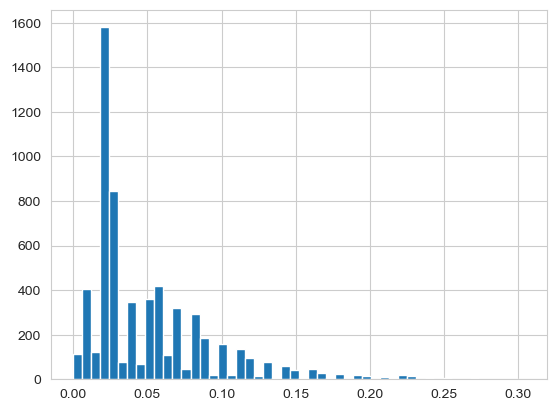

In [10]:
df.OTHER.hist(bins=50)

In [11]:
#df = df.query("OTHER > 0") #It seems the natural zeros are gone

Two way Biden vs Trump, Biden loses by 0.3%. Kamala loses by 4.8%. This is because Kamala's polling occured more after the race moved in Trump's favor.

In [12]:
df_2way.query("state == 'US'")[['DEM', 'GOP']].describe()

,DEM,GOP
count,1640.000000,1640.000000
mean,0.501685,0.422207
std,0.031766,0.030283
min,0.370000,0.300000
25%,0.488000,0.408400
50%,0.510000,0.420000
75%,0.521725,0.443825
max,0.590000,0.518000


In [13]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2019, and increased exponentially through election day.

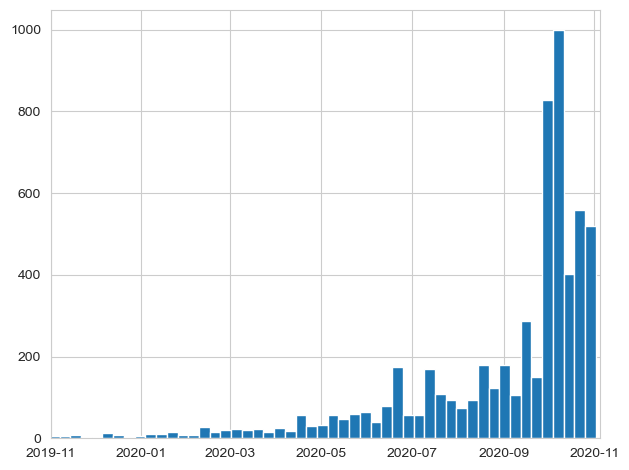

In [14]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2019, 11, 1), dt.datetime(2020, 11, 5))

plt.tight_layout()
plt.show()

In [15]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Probability Panel,IVR/Online Panel,IVR/Text,Live Phone/Online Panel,Text-to-Web/Online Ad,Online Ad,Online Panel/Text-to-Web,Online Panel/Online Ad
pollster,,,,,,,,,,,
All,6137,4036,729,415,165,117,111,107,57,51,50
SurveyMonkey,2843,2843,0,0,0,0,0,0,0,0,0
Morning Consult,468,467,1,0,0,0,0,0,0,0,0
USC Dornsife,214,0,0,214,0,0,0,0,0,0,0
Ipsos,191,1,0,190,0,0,0,0,0,0,0
YouGov,162,162,0,0,0,0,0,0,0,0,0
Change Research,111,2,0,0,0,0,0,107,2,0,0
Data for Progress,96,45,0,0,0,0,0,0,0,50,0
Redfield & Wilton Strategies,94,88,6,0,0,0,0,0,0,0,0


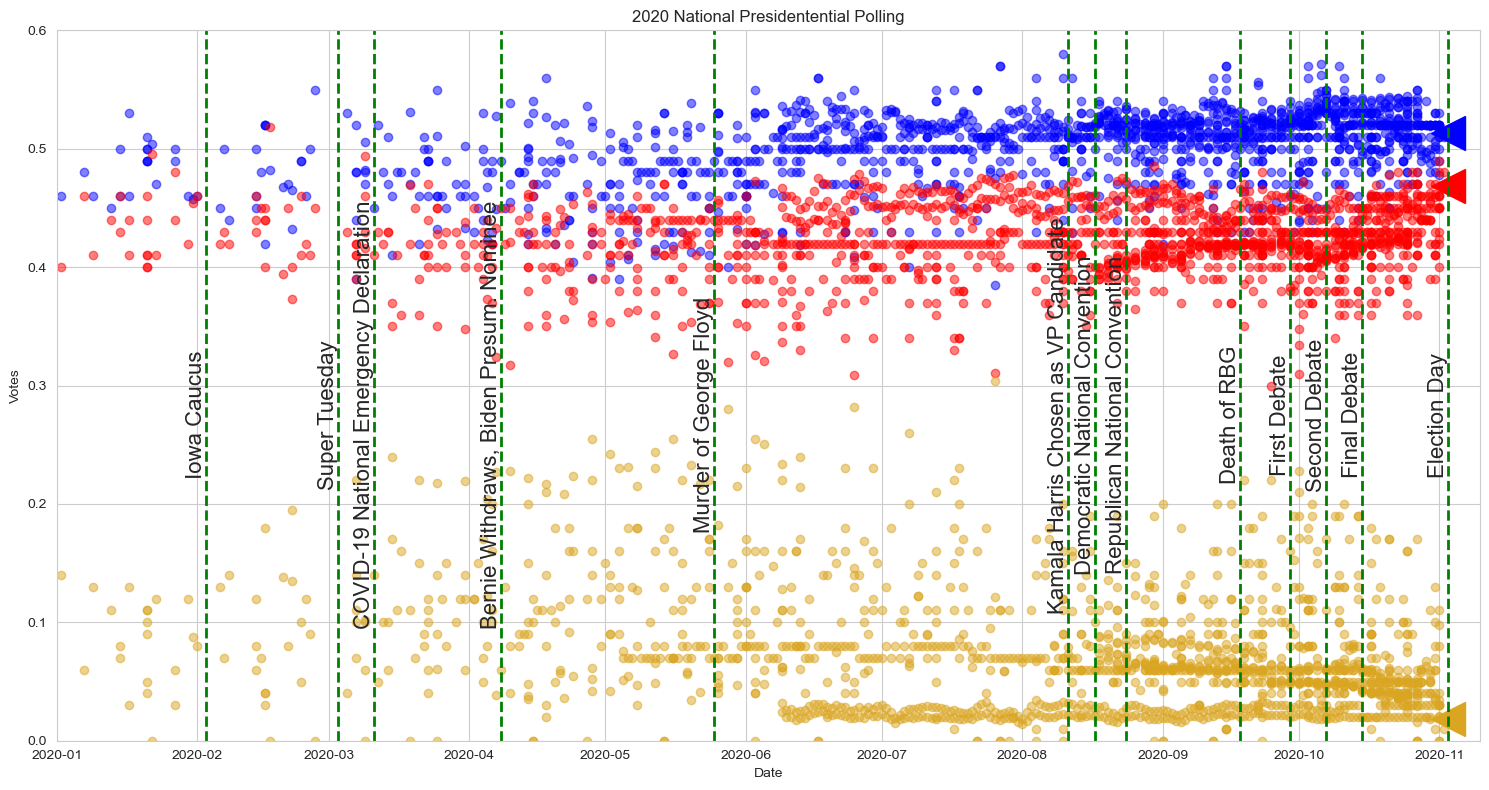

In [16]:
dem_votes = df.query("state == 'US'")["DEM"].values
gop_votes = df.query("state == 'US'")["GOP"].values
oth_votes = df.query("state == 'US'")["OTHER"].values

dates = df.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.5, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.5, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.5, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2020 National Presidentential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 2, 3), 'Iowa Caucus'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

ax.plot(dt.datetime(2020, 11, 3), .5131, "<", markersize=25, color='blue', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .4685, "<", markersize=25, color='red', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .0184, "<", markersize=25, color='goldenrod', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.275, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Daily standard deviation in polls')

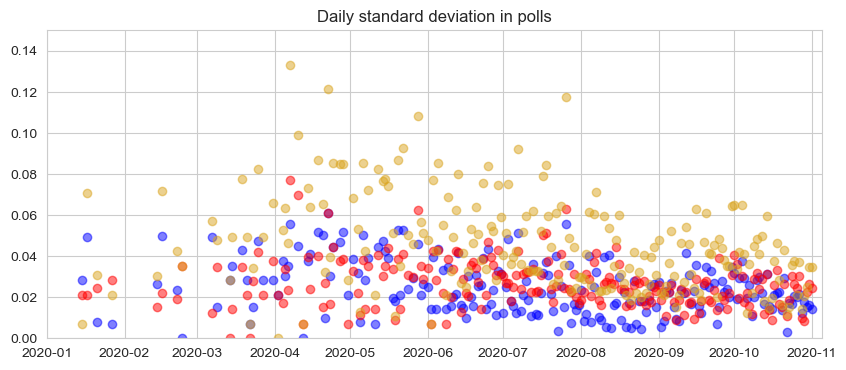

In [17]:
rolling_std = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .reset_index()
    .groupby(["date"])
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.DEM.values,
    "o",
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.GOP.values,
    "o",
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.OTHER.values,
    "o",
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .15)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 5))
ax.set_title("Daily standard deviation in polls")

We can see here that polling methodology is irrelevant, they all perform about the same.

In [18]:
df.query("state == 'US'").query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'IVR/Online Panel', 'IVR/Text', 'Live Phone/Online Panel', 'Text-to-Web/Online Ad']")[['methodology','DEM','GOP']].groupby("methodology").mean()

,DEM,GOP
methodology,,
IVR/Online Panel,0.497260,0.450261
IVR/Text,0.485000,0.410000
Live Phone,0.508236,0.417637
Live Phone/Online Panel,0.499002,0.436913
Online Panel,0.501441,0.427734
Probability Panel,0.502296,0.403561
Text-to-Web/Online Ad,0.497400,0.429920


In [19]:
df.columns

Index(['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date', 'date',
       'year', 'month', 'day', 'week', 'DEM', 'GOP', 'type', 'obs_id',
       'OTHER'],
      dtype='object')

In [20]:
df.query("state == 'US'").groupby("population")['DEM'].mean()

population
a     0.462263
lv    0.510726
rv    0.498613
Name: DEM, dtype: float64

We can see that Trump fairly consistently out-performs on App Panel polls.

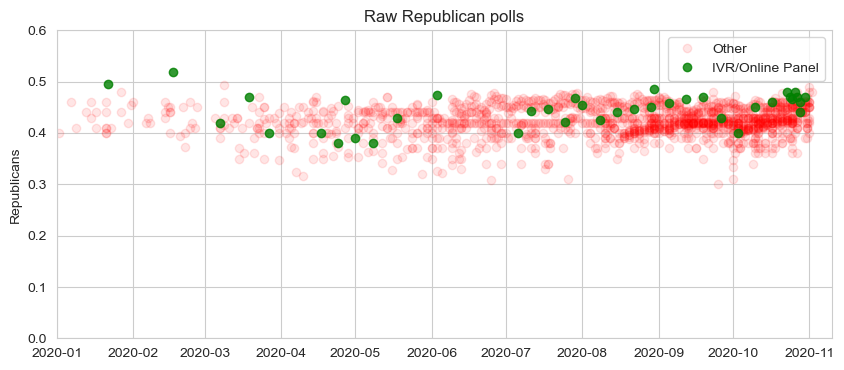

In [21]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "IVR/Online Panel"]
face = face.set_index("date")
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "IVR/Online Panel"]
other = other.set_index("date")
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.1, color = 'red', label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, color = 'green', label="IVR/Online Panel")
ax.set_ylim(0, .6)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 10))
ax.legend()

In [22]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [23]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,field_date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,type,obs_id,OTHER,margin,GOP_mean,DEM_mean,margin_mean,diff_GOP,diff_DEM,diff_margin
0,0,73830,138491,940,Lake Research,Live Phone,US,lv,2400.0,2020,...,2way,0,0.01,0.03,0.46,0.50,0.04,0.02,0.01,-0.01
1,1,74946,142781,1677,The Political Matrix/The Listener Group,IVR,FL,lv,966.0,2020,...,2way,1,0.08,-0.04,0.46,0.50,0.04,0.02,-0.06,-0.08
2,2,72621,136283,383,PPP,IVR/Text,IA,v,871.0,2020,...,2way,2,0.03,0.01,0.46,0.50,0.04,0.02,-0.01,-0.03
3,3,72647,136322,461,Susquehanna,Live Phone,PA,lv,499.0,2020,...,2way,3,0.02,-0.01,0.46,0.50,0.04,0.03,-0.02,-0.05
4,4,72722,136491,235,InsiderAdvantage,IVR/Live Phone,FL,lv,400.0,2020,...,2way,4,0.05,-0.01,0.46,0.50,0.04,0.02,-0.03,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6132,6132,57472,93051,1240,Øptimus,Live Phone,US,lv,1064.0,2020,...,2way,6132,0.14,0.04,0.44,0.49,0.05,-0.04,-0.04,-0.01
6133,6133,57427,92926,176,Glengariff Group Inc.,Live Phone,MI,lv,600.0,2020,...,2way,6133,0.06,0.13,0.40,0.53,0.13,0.00,0.00,0.00
6134,6134,57365,92773,383,PPP,IVR/Online Panel,US,rv,760.0,2020,...,2way,6134,0.06,0.12,0.41,0.53,0.12,0.00,0.00,0.00
6135,6135,57275,92597,383,PPP,IVR/Online Panel,NC,rv,750.0,2020,...,2way,6135,0.07,0.05,0.44,0.49,0.05,0.00,0.00,0.00


In [24]:
df.groupby('type')[['margin']].mean()

,margin
type,
2way,0.05526


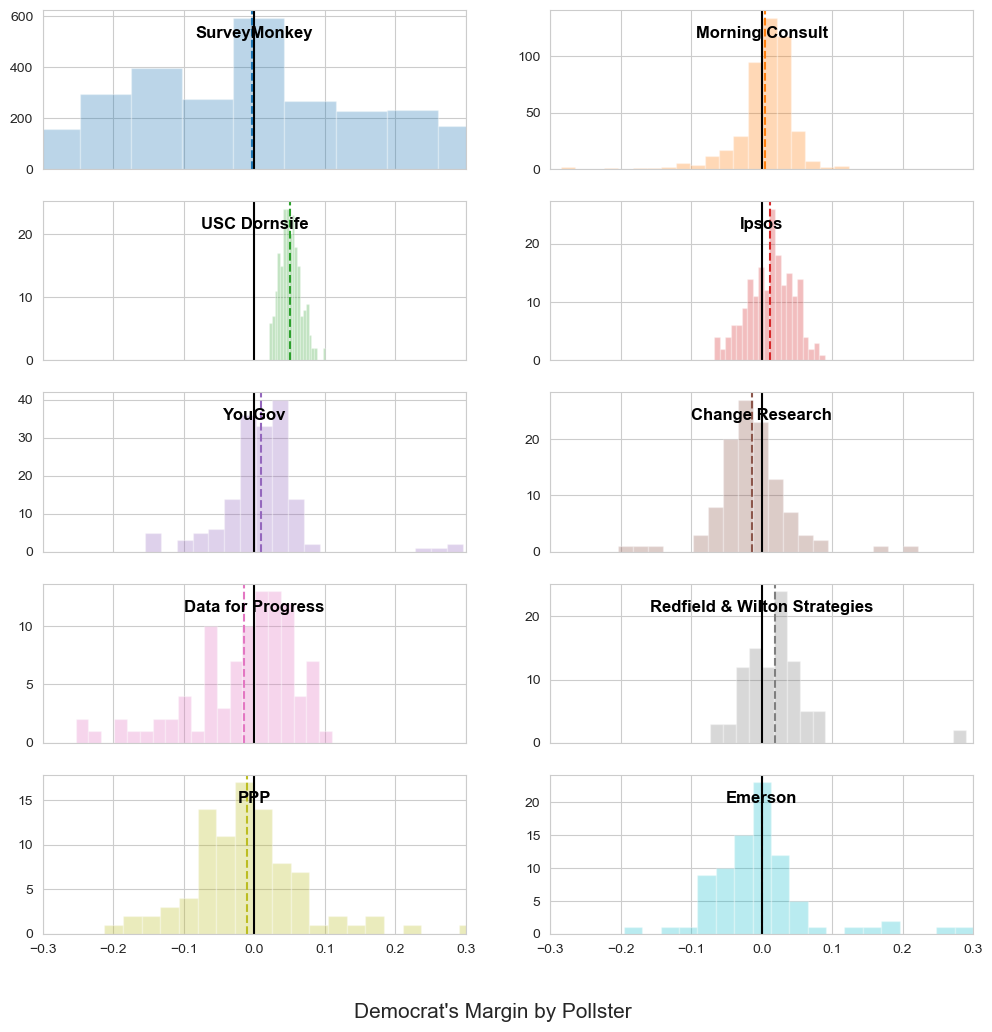

In [25]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.3, .3)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


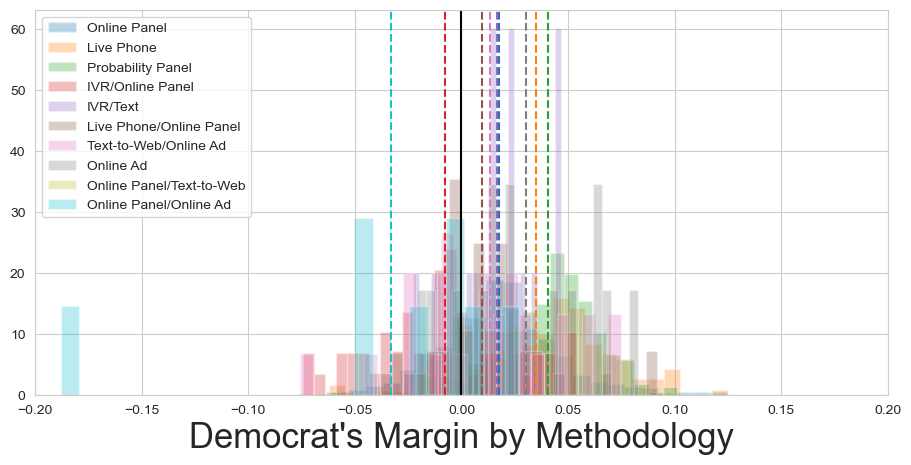

In [26]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25, density=True)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-.2, .2)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [27]:
date_counts = df['date'].value_counts().reset_index()

# Rename the columns
date_counts.columns = ['date', 'count']

# Sort the DataFrame by date in descending order
date_counts = date_counts.sort_values(by='date', ascending=False).reset_index(drop=True)

print(date_counts)

          date  count
0   2020-11-02      5
1   2020-11-01     19
2   2020-10-31     62
3   2020-10-30     37
4   2020-10-29     64
..         ...    ...
424 2019-01-31      2
425 2019-01-25      1
426 2019-01-20      1
427 2019-01-06      1
428 2018-12-17      1

[429 rows x 2 columns]


In [28]:
#df = df[df['date'] < '2020-07-30'] #Use today's date in 2020

In [29]:
day_id, day = df.set_index(
    ["day"]
).index.factorize(sort=True)

In [30]:
day

Index([-688, -668, -654, -649, -643, -642, -631, -630, -628, -622,
       ...
        -11,  -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2],
      dtype='int64', length=429)

In [31]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id, day = df.set_index(
    ["day"]
).index.factorize(sort=True)
day = np.concatenate([day, np.arange(max(day)+1, 1)])

party_id, party = [0,1,2], ['DEM','GOP','Other']

week = np.arange(min(week), 1)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [33]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 3,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect   = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 3,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.2, dims="pollster")
    gop_method_effect   = pm.Normal("gop_method_effect", 0, 0.2, dims="method")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.2, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.2, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.2, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 3,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.2, dims="pollster")
    oth_method_effect   = pm.Normal("oth_method_effect", 0, 0.2, dims="method")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.2, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.2, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.2, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    # Binomial likelihoods
    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_dem = pm.Normal("polling_error_dem", 0, .1)
    polling_error_gop = pm.Normal("polling_error_gop", 0, .1)
    polling_error_oth = pm.Deterministic("polling_error_oth",-(polling_error_dem + polling_error_gop))

    # Sampling
    idata = pm.sample(draws=100, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_dem, polling_error_gop]
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pytensor/compile/function/types.py:1138: UserWarning: aliased relationship between Function arguments 431, 431 will not be preserved by un-pickling operation
  warnings.warn(


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 4991 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 4 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 9 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A high

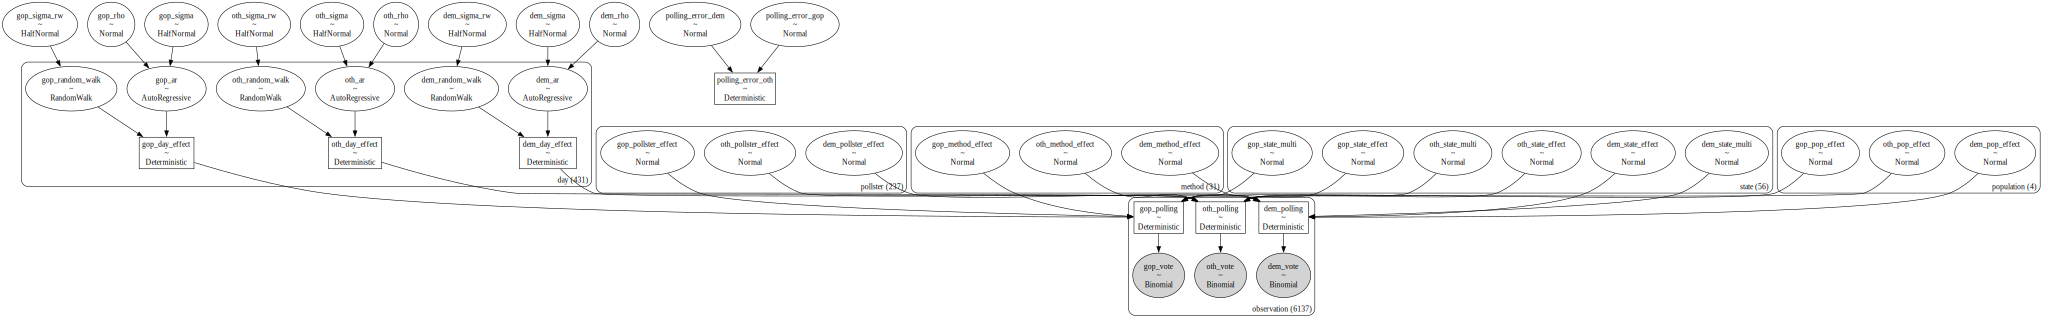

In [34]:
pm.model_to_graphviz(twoway)

In [35]:
z = pd.DataFrame()
z['state'] = idata.posterior.state
z['dem_state_multi'] = idata.posterior.dem_state_multi.mean(axis=0).mean(axis=0).values
z['dem_state_effect'] = idata.posterior.dem_state_effect.mean(axis=0).mean(axis=0).values
z['gop_state_multi'] = idata.posterior.gop_state_multi.mean(axis=0).mean(axis=0).values
z['gop_state_effect'] = idata.posterior.gop_state_effect.mean(axis=0).mean(axis=0).values
z['oth_state_multi'] = idata.posterior.oth_state_multi.mean(axis=0).mean(axis=0).values
z['oth_state_effect'] = idata.posterior.oth_state_effect.mean(axis=0).mean(axis=0).values

In [36]:
z.sort_values(by='state')

,state,dem_state_multi,dem_state_effect,gop_state_multi,gop_state_effect,oth_state_multi,oth_state_effect
0,AK,0.836617,-0.302115,0.952752,0.261475,0.918466,0.035076
1,AL,0.968915,-0.508905,0.912655,0.491820,0.920148,-0.128149
2,AR,1.192566,-0.501591,1.312159,0.472953,1.015715,-0.085549
3,AZ,1.596657,0.012802,1.338494,-0.027362,1.350510,0.332070
4,CA,0.047495,0.417331,-0.218078,-0.394700,1.152565,0.192693
5,CO,1.222261,0.240410,1.197439,-0.256653,1.119339,0.001799
6,CT,0.970647,0.408813,1.207391,-0.467126,0.952907,0.144095
7,DC,0.760817,1.892371,0.585996,-2.067019,0.989951,0.030885
8,DE,0.688731,0.443010,0.909018,-0.456818,1.106884,-0.040419
9,FL,0.149881,-0.104209,0.205085,0.117802,1.220780,0.257710


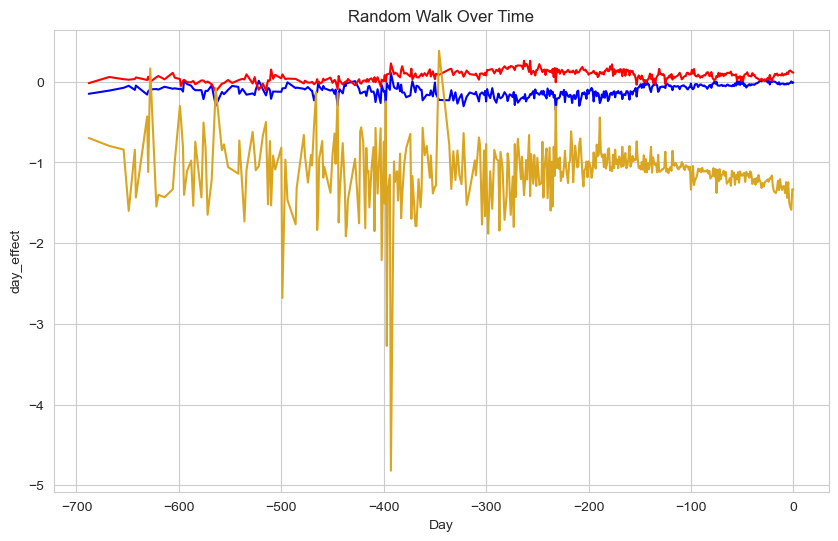

In [37]:
dem = pd.DataFrame()
dem['day'] = idata.posterior.day
dem['day_effect'] = idata.posterior.dem_day_effect.mean(axis=0).mean(axis=0).values

gop = pd.DataFrame()
gop['day'] = idata.posterior.day
gop['day_effect'] = idata.posterior.gop_day_effect.mean(axis=0).mean(axis=0).values

oth = pd.DataFrame()
oth['day'] = idata.posterior.day
oth['day_effect'] = idata.posterior.oth_day_effect.mean(axis=0).mean(axis=0).values

plt.figure(figsize=(10, 6))
plt.plot(dem['day'], dem['day_effect'], color='blue', label='Democrats', linestyle='-')
plt.plot(gop['day'], gop['day_effect'], color='red', label='Republicans', linestyle='-')
plt.plot(oth['day'], oth['day_effect'], color='goldenrod', label='Other', linestyle='-')
plt.xlabel('Day')
plt.ylabel('day_effect')
plt.title('Random Walk Over Time')
plt.grid(True)
plt.show()

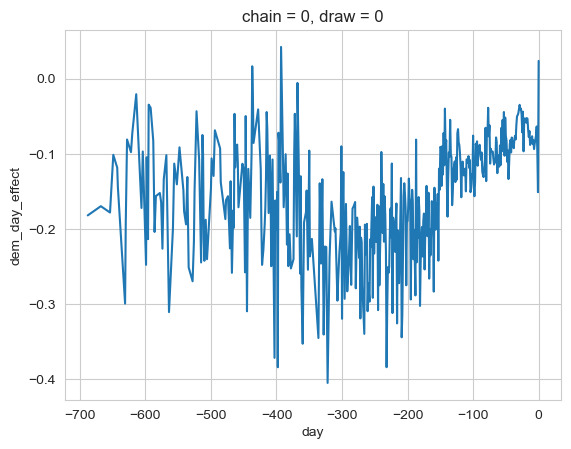

In [38]:
idata.posterior.dem_day_effect.sel(chain=0, draw=0).plot()

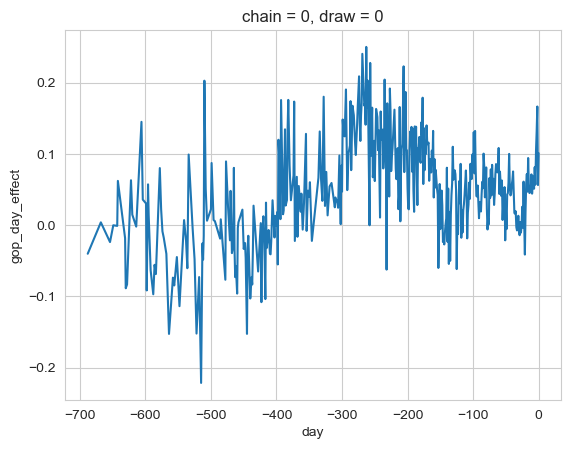

In [39]:
idata.posterior.gop_day_effect.sel(chain=0, draw=0).plot()

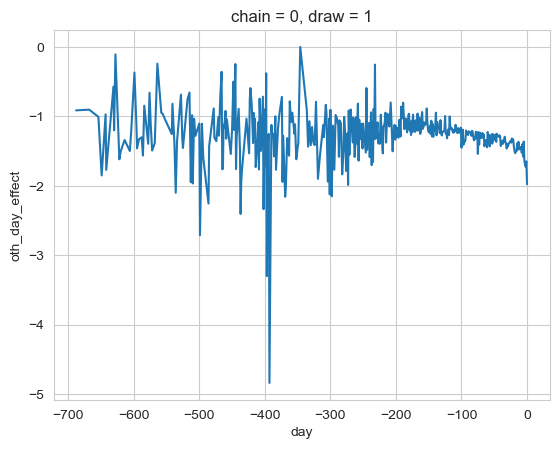

In [40]:
idata.posterior.oth_day_effect.sel(chain=0, draw=1).plot()

In [41]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [42]:
interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = (
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Ipsos") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Emerson") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Monmouth") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Quinnipiac") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="ABC/Washington Post") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marist") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marquette Law School") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Suffolk") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="U. Massachusetts - Lowell")
    ).values / 11
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    method_effects = (
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone/Online Panel', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'IVR/Live Phone/Text/Online Panel/Email', drop=True).mean(axis=2)
    )/4
    method_effects_flat = pollster_effects.ravel()
    interim[f"method_effects_{party}"] = pollster_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"polling_error_{party}"] = idata.posterior[f"polling_error_{party}"].values.ravel()

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] + interim[f"method_effects_{party}"] + interim[f"pop_effects_{party}"] + interim[f"polling_error_{party}"]

In [43]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

for d in tqdm(day):
#for d in [-100]:
    for state in states:
        for party in ['dem','gop','oth']:
            df_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
            ).values.ravel()
            
        state_columns = [f"{state}_dem", f"{state}_gop", f"{state}_oth"]
        df_results[f"{state}_dem"] = df_results[f"{state}_dem"] + df_results[f"{state}_oth"] / 4
        df_results[f"{state}_gop"] = df_results[f"{state}_gop"] + df_results[f"{state}_oth"] / 4
        df_results[f"{state}_oth"] = df_results[f"{state}_oth"] / 2
        df_results[f"{state}_total"] = df_results[state_columns].sum(axis=1)

        for col in state_columns:
            df_results[col] = df_results[col] / df_results[f"{state}_total"]
        
        df_results[f"{state}_margin"] = df_results[f"{state}_dem"] - df_results[f"{state}_gop"]

    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

  0%|                                                   | 0/431 [00:00<?, ?it/s]/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3529626392.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f"{state}_total"] = df_results[state_columns].sum(axis=1)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3529626392.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f"{state}_total"] = df_results[state_columns].sum(axis=1)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel

<Axes: >

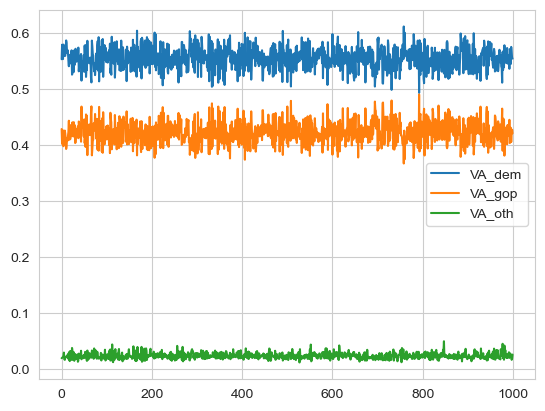

In [44]:
df_results[['VA_dem','VA_gop','VA_oth']].plot()

In [45]:
pd.date_range(start=df.date.min(), end='2024-11-03')

DatetimeIndex(['2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-25', '2018-12-26',
               ...
               '2024-10-25', '2024-10-26', '2024-10-27', '2024-10-28',
               '2024-10-29', '2024-10-30', '2024-10-31', '2024-11-01',
               '2024-11-02', '2024-11-03'],
              dtype='datetime64[ns]', length=2149, freq='D')

In [46]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2020-11-04')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True)
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True)
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True)
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True)
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True)

In [47]:
min(df_day_mean.index)

-688

In [48]:
df_day_mean = df_day_mean.reset_index().set_index('date')
df_day_03 = df_day_03.reset_index().set_index('date')
df_day_25 = df_day_25.reset_index().set_index('date')
df_day_75 = df_day_75.reset_index().set_index('date')
df_day_97 = df_day_97.reset_index().set_index('date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3726752768.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3726752768.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

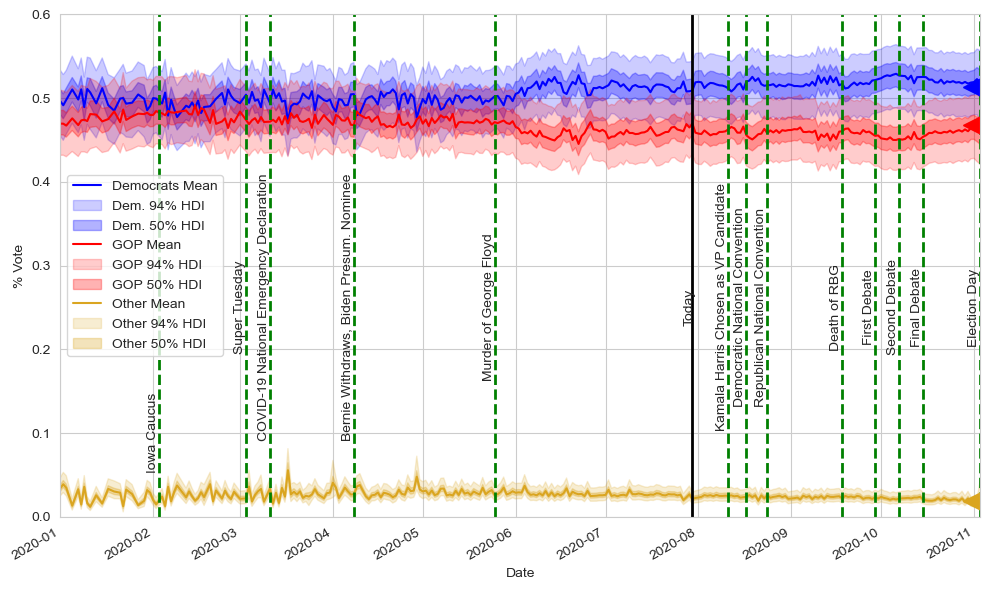

In [49]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

df_day_mean[f"{graph_state}_oth"].plot(color='goldenrod', label='Other Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].ffill(), df_day_97[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.2, label='Other 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].ffill(), df_day_75[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.3, label='Other 50% HDI')

dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]
oth_votes = df.set_index('date').query(f"state == '{graph_state}'")["OTHER"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")
#ax.plot(oth_votes.index, oth_votes, "o", alpha=.5, markersize=3, color='goldenrod', label="Poll Other %")

# Set limits and labels
ax.set_ylim(0,.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 7, 30), color='black', linestyle='-', linewidth=2)
plt.text(dt.datetime(2020, 7, 31), 0.25, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 2, 3), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2020, 2, 3), 0.1, 'Iowa Caucus', rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.plot(dt.datetime(2020, 11, 3), .5131, "<", markersize=25, color='blue', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .4685, "<", markersize=25, color='red', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .0184, "<", markersize=25, color='goldenrod', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3969073170.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/3969073170.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

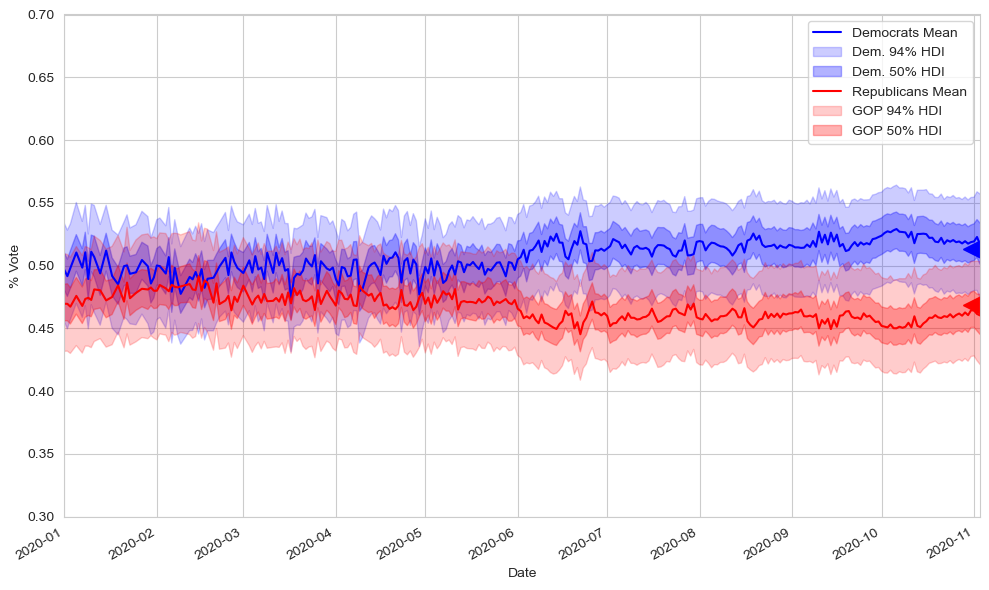

In [50]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

#df_day_mean[f"{graph_state}_oth"].plot(color='goldenrod', label='Other Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].ffill(), df_day_97[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.2, label='GOP 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].ffill(), df_day_75[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.3, label='GOP 50% HDI')

dem_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(.3,.7)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3) #datetime.datetime.today()
           )
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            #(dt.datetime(2024, 1, 15), 'GOP Iowa Caucus'),
            #(dt.datetime(2024, 3,  5), 'Super Tuesday'),
            #(dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            #(dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            #(dt.datetime(2024, 6, 27), 'First Debate'),
            #(dt.datetime(2024, 7, 15), 'GOP Convention'),
            #(dt.datetime(2024, 8, 19), 'Dem. Convention'),
            #(dt.datetime(2024, 9, 10), 'Second Debate'),
            #(dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            #(dt.datetime(2024, 11, 5), 'Election Day'),
         ]

ax.plot(dt.datetime(2020, 11, 3), .5131, "<", markersize=25, color='blue', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .4685, "<", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

In [51]:
# List of states to loop over
state_loop = ['TX', 'CA', 'MN', 'MI', 'FL', 'GA', 'US','WI','PA','AZ','NV','NC', 'NY']

# Loop over each state
for state in state_loop:
    graph_state = state
    
    # Create a new figure for each state
    plt.figure(figsize=(10, 6))
    
    # Define the bin edges, ensuring that they align perfectly
    bin_edges = np.arange(-0.3, 0.31, 0.01)
    
    # Plot the histogram using the pre-defined bins
    ax = sns.histplot(df_results[f"{graph_state}_margin"], bins=bin_edges, kde=False, stat="probability")
    
    # Get patches from the Axes
    for patch in ax.patches:
        # Get x midpoint of bar
        x = patch.get_x() + 0.5 * patch.get_width()
        
        # Set bar color based on x
        if x < 0:
            patch.set_facecolor('red')
        elif x > 0:
            patch.set_facecolor('blue')
        elif x == 0:
            patch.set_facecolor('lime')
    
    # Add titles and labels
    plt.title(f'2024 Today - {state} Margin')
    plt.xlabel('Democratic Margin')
    plt.xlim(-0.3, 0.3)
    plt.ylabel('Probability')
        
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'2way_enight_{state.lower()}.png')
    
    # Close the figure to avoid overlapping
    plt.close()


In [52]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [53]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

32    NE-3
Name: state_code, dtype: object

In [54]:
#df_winner[['AR', 'ID', 'KS', 'KY', 'ME-2', 'MS', 'NE-1', 'NE-3', 'ND', 'WY']] = 'gop'
#df_winner[['CT', 'DE', 'IL','ME-1', 'NE-2', 'DC']] = 'dem'

#df_winner[['NE-1', 'NE-3']] = 'gop'
#df_winner[['DE','DC']] = 'dem'

df_winner['NE-3'] = df_winner['WY']

state_order = df_state['state_code'].to_list

In [55]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36842/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [67]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['dem_pop'] = df_winner_dem['US']
df_ec['gop_pop'] = df_winner_gop['US']

In [68]:
pct_dem_wo_pop = 100*len(df_ec.query("(gop_pop == 1) & (dem > 269)"))/len(df_ec)
pct_gop_wo_pop = 100*len(df_ec.query("(dem_pop == 1) & (gop > 269)"))/len(df_ec)

print("% Chance of a Win without Popular Vote")
print("-------------------------------------")
print(" Democrats:   " + str(round(pct_dem_wo_pop,2)))
print(" Republicans: " + str(round(pct_gop_wo_pop,2)))
print(" Total:       " + str(round(pct_dem_wo_pop+pct_gop_wo_pop,2)))

% Chance of a Win without Popular Vote
-------------------------------------
 Democrats:   0.0
 Republicans: 8.8
 Total:       8.8


In [57]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(82.69999999999999, 0.0, 17.299999999999997)

In [58]:
df_ec.max()

dem    444
gop    342
dtype: int64

In [59]:
df_ec.min()

dem    196
gop     94
dtype: int64

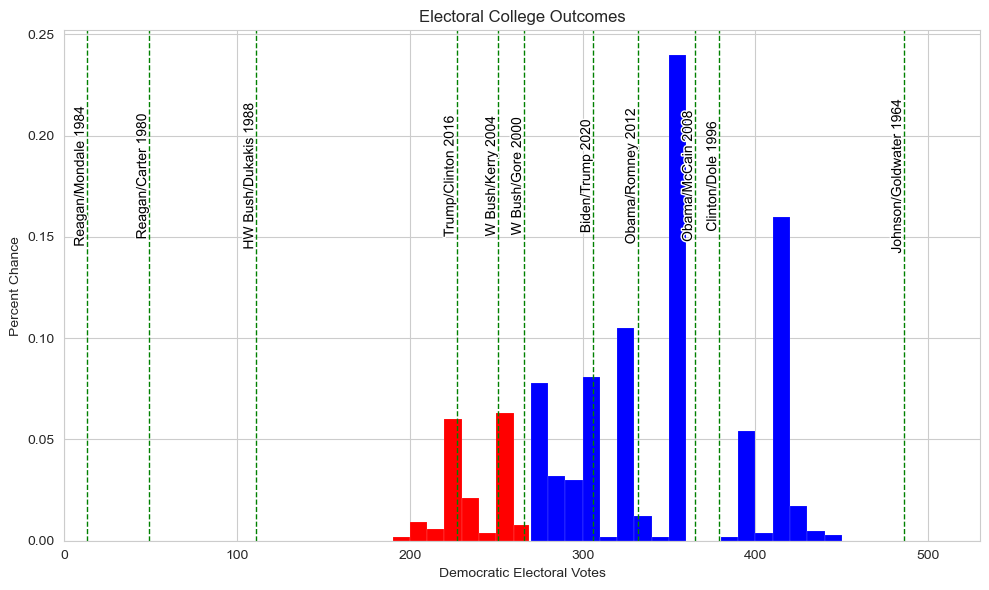

In [60]:
plt.figure(figsize=(10, 6))

bins = list(range(0, 269, 10)) + [269] + list(range(270, 540, 10))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_ec['dem'], bins=bins, kde=False, stat="probability")

# Get patches from the Axes
max_height = max([patch.get_height() for patch in ax.patches])

# Get the lowest and highest x values from the histogram bars
lowest_bar = min([patch.get_x() for patch in ax.patches])
highest_bar = max([patch.get_x() + patch.get_width() for patch in ax.patches])

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() #+ 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('lime')

# Adding titles and labels
#plt.title('2024 Election Night - Electoral College Results')
plt.title('Electoral College Outcomes')
plt.xlabel('Democratic Electoral Votes')
plt.xlim(lowest_bar, highest_bar)
plt.ylabel('Percent Chance')

events = [
    (13, 'Reagan/Mondale 1984'),
    (49, 'Reagan/Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    (486, 'Johnson/Goldwater 1964')
]

label_position = 3/4 * max_height

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    text = plt.text(date, label_position, event, rotation=90, verticalalignment='center', 
                    horizontalalignment='right', fontsize=10, color='black')
    
    # Add white outline to the text
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                           path_effects.Normal()])

plt.tight_layout()
# Display the plot
plt.savefig('2way_enight_ec.png')

In [61]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]
    df_oth[state] = df_results[f"{state}_oth"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['oth'] = df_oth.mean()
df_mean['margin'] = df_margin.mean()

In [62]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [63]:
df_win_pct.sort_values('dem')

,dem,gop
NE-3,0.000,1.000
MS,0.000,1.000
OK,0.000,1.000
LA,0.000,1.000
KY,0.000,1.000
SD,0.000,1.000
TN,0.000,1.000
UT,0.000,1.000
IN,0.000,1.000
ID,0.000,1.000


In [64]:
df_mean.sort_values('margin')

,dem,gop,margin,oth
WY,0.311584,0.671653,-0.360069,0.016763
WV,0.320311,0.664246,-0.343935,0.015443
OK,0.377317,0.607684,-0.230367,0.014998
ND,0.380528,0.605324,-0.224796,0.014148
AR,0.383043,0.597921,-0.214878,0.019037
AL,0.384310,0.595187,-0.210877,0.020504
ID,0.384228,0.594708,-0.210480,0.021063
KY,0.395694,0.587960,-0.192266,0.016346
MS,0.398271,0.584801,-0.186531,0.016928
LA,0.396397,0.577781,-0.181384,0.025822


In [65]:
df_day_mean.US_dem.tail(110).head(20)

date
2020-07-18    0.516359
2020-07-19    0.516323
2020-07-20    0.515958
2020-07-21    0.514158
2020-07-22    0.513105
2020-07-23    0.508361
2020-07-24    0.507119
2020-07-25    0.511887
2020-07-26    0.512063
2020-07-27    0.520089
2020-07-28    0.508128
2020-07-29    0.508303
2020-07-30    0.509198
2020-07-31    0.518949
2020-08-01    0.519551
2020-08-02    0.518985
2020-08-03    0.512173
2020-08-04    0.515924
2020-08-05    0.518299
2020-08-06    0.517865
Name: US_dem, dtype: object